##  Gaussian Mixture Models

Resources: 
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details: 
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

class GMM:
    def __init__(self, n_components=1, tol=1e-3, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.weights = None  # pie
        self.means = None  # mu
        self.covars = None  # Covariance matrices

    def initialize_params(self, X):
        n_samples, n_features = X.shape
        self.means = X[np.random.choice(n_samples, self.n_components, False)]
        self.covars = np.array([np.cov(X.T) + np.eye(n_features) * 1e-6 for _ in range(self.n_components)])
        self.weights = np.ones(self.n_components) / self.n_components

    def E_step(self, X):
        """       
        responsibility using the formula:
        gamma(z_nk) = (pi_k * N(x_n | mu_k, Sigma_k)) / sum(pi_j * N(x_n | mu_j, Sigma_j)),
        where N is the Gaussian distribution, pi_k are the weights, and mu_k, Sigma_k are the mean and covariance of the k-th component.
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            rv = multivariate_normal(mean=self.means[k], cov=self.covars[k])
            responsibilities[:, k] = self.weights[k] * rv.pdf(X)
        
        responsibilities_sum = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities = responsibilities / responsibilities_sum
        
        return responsibilities

    def M_step(self, X, responsibilities):
        """
        model updates parameters using the following formulas:
        mu_k = sum(gamma(z_nk) * x_n) / sum(gamma(z_nk)),
        Sigma_k = sum(gamma(z_nk) * (x_n - mu_k) * (x_n - mu_k).T) / sum(gamma(z_nk)),
        pi_k = sum(gamma(z_nk)) / N,
        where N is the total number of data points.
        """
        n_samples, n_features = X.shape
        weights = responsibilities.sum(axis=0)
        self.weights = weights / n_samples
        self.means = np.dot(responsibilities.T, X) / weights[:, np.newaxis]
        
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covars[k] = np.dot(responsibilities[:, k] * diff.T, diff) / weights[k]
            self.covars[k] += np.eye(n_features) * 1e-6  # Regularization term for numerical stability
        
    def fit(self, X, y=None):
        self.initialize_params(X)
        log_likelihood = 0
        
        for i in range(self.max_iter):
            responsibilities = self.E_step(X)
            self.M_step(X, responsibilities)
            new_log_likelihood = np.sum(np.log(np.sum([k.pdf(X) for k in [multivariate_normal(mean=self.means[j], cov=self.covars[j]) for j in range(self.n_components)]], axis=0)))
            
            if np.abs(new_log_likelihood - log_likelihood) <= self.tol:
                break
            
            log_likelihood = new_log_likelihood
            
    def predict(self, X):
        responsibilities = self.E_step(X)
        return np.argmax(responsibilities, axis=1)

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        orientation = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        orientation = 0
        width = height = 2 * np.sqrt(covariance)
    
    for nsig in range(1, 4):
        ell = Ellipse(xy=position, width=nsig * width, height=nsig * height, angle=orientation, **kwargs)
        ax.add_patch(ell)



# np.random.seed(0)
# n_samples = 500
# C = np.array([[0., -1.1], [1.7, .4]])
# X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
#           .5 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# gmm = GMM(n_components=2)
# gmm.fit(X)

# labels = gmm.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', zorder=2)

# for mean, covar in zip(gmm.means, gmm.covars):
#     draw_ellipse(mean, covar, alpha=0.2, color='red')

# plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', marker='X', s=100, zorder=3)
# plt.title('GMM Clustering')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [3]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'
print(source_path)

./videos/traffic.gif


In [4]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"
print(frames_path)


./frames/traffic


In [5]:
%%capture

!mkdir -p {frames_path} > $null ;
#  mkdir -p ./frames/traffic > $null

In [6]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > $null ;
# ffmpeg -i ./videos/traffic.gif ./frames/traffic/'frame_%04d.png' > $null ;

#### Loading Frames

In [7]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)
print(frames.shape)


(80, 120, 160, 3)


#### Splitting the data

In [8]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) 
print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps) 
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

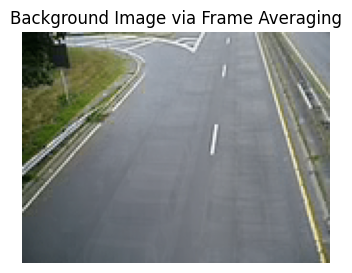

In [9]:
background_image_avg = np.mean(train_frames, axis=0)

# values are within the range [0, 1]  
background_image_display_avg = np.clip(background_image_avg, 0, 1)
background_image_display_avg = (background_image_display_avg * 255).astype(np.uint8)

plt.figure(figsize=(6, 3))
plt.imshow(background_image_display_avg)
plt.axis('off')
plt.title('Background Image via Frame Averaging')
plt.show()


#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

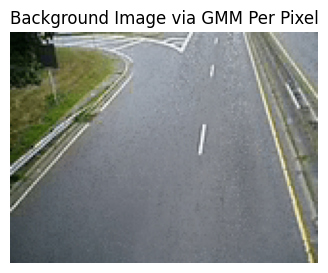

In [10]:
num_frames, height, width, _ = train_frames.shape

background_model = np.zeros((height, width, 3))

for i in range(height):
    for j in range(width):
        pixel_values = train_frames[:, i, j, :].reshape(-1, 3)
        gmm = GMM(n_components=2)
        gmm.fit(pixel_values)

        bg_component_index = np.argmax(gmm.weights)
        background_model[i, j, :] = gmm.means[bg_component_index]

background_image_display_gmm = np.clip(background_model, 0, 1)
background_image_display_gmm = (background_image_display_gmm * 255).astype(np.uint8)

plt.figure(figsize=(6, 3))
plt.imshow(background_image_display_gmm)
plt.axis('off')
plt.title('Background Image via GMM Per Pixel')
plt.show()


#### Extract Background Image from the trained model

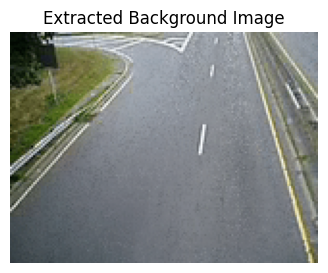

In [11]:
background_model_clipped = np.clip(background_model, 0, 1)

background_image_display = (background_model_clipped * 255).astype(np.uint8)

plt.figure(figsize=(6, 3))
plt.imshow(background_image_display)
plt.axis('off')  
plt.title('Extracted Background Image')
plt.show()

from PIL import Image
background_image_pil = Image.fromarray(background_image_display)
background_image_pil.save('extracted_background.png')

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [12]:
def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()



def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
        vid_wrt.write(frame)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

In [13]:
def extract_foreground(test_frame, background_image, threshold=0.25):
    foreground = np.abs(test_frame - background_image / 255.0)
    foreground_mask = np.max(foreground, axis=-1) > threshold
    foreground = np.where(foreground_mask[:, :, None], test_frame, 0)
    return foreground

In [14]:
# def extract_background(test_frame, foreground_image, threshold=0.25):
#     background = np.abs(test_frame - foreground_image / 255.0)
#     # background_mask = np.max(background, axis=-1) > threshold
#     background = np.where(background_mask[:, :, None], test_frame, 0)
#     return background

### foreground iMAGE

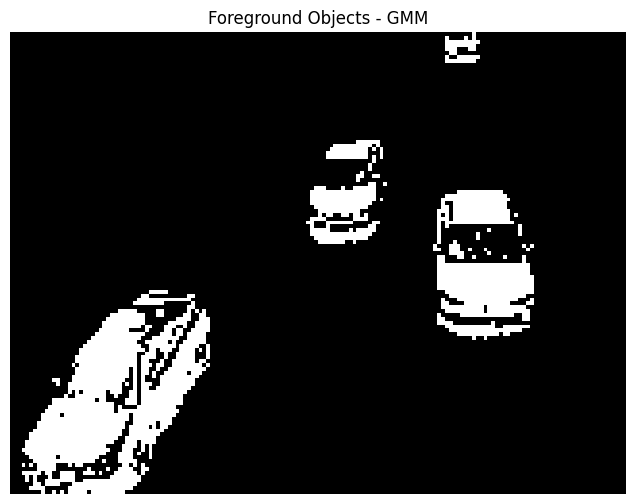

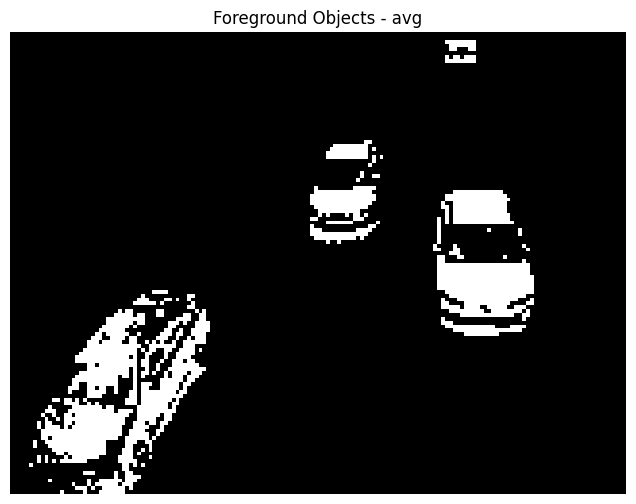

In [15]:
test_frame = test_frames[0]

foreground = np.abs(test_frame - background_image_display_gmm / 255.0)

foreground_mask = np.max(foreground, axis=-1) > 0.25
plt.figure(figsize=(10, 6))
plt.imshow(foreground_mask, cmap='gray')
plt.axis('off')
plt.title('Foreground Objects - GMM')
plt.show()


foreground1 = np.abs(test_frame - background_image_display_avg / 255.0)
foreground_mask1 = np.max(foreground1, axis=-1) > 0.3
plt.figure(figsize=(10, 6))
plt.imshow(foreground_mask1, cmap='gray')
plt.axis('off')
plt.title('Foreground Objects - avg')
plt.show()


### Frame Averaging

In [16]:
foreground_frames = []

for frame in test_frames:
    foreground = extract_foreground(frame, background_image_display_avg)
    foreground_frames.append(foreground)

display_frames(foreground_frames)
save_frames(foreground_frames,  file_name='average_foreground')

#### GMMs per pixel

In [ ]:
foreground_frames = []

for frame in test_frames:
    foreground = extract_foreground(frame, background_image_display_gmm)
    foreground_frames.append(foreground)

display_frames(foreground_frames)
save_frames(foreground_frames,  file_name='gmm_foreground')